In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import sqlite3 
import numpy as np
import json
import math
from tqdm.notebook import tqdm
from tqdm import tqdm
tqdm.pandas()
import calendar
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import Advan_operator as ad_op  

pd.set_option('display.max_columns', 20)

# Loading data

In [6]:
data_path = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population'
save_path = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population' 

years = [2022]
# months = list(range(1, 13))
months = [1]

landscan_daytime_fname =   r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test\Landscan_daytime_2021_CBG.csv"
landscan_nighttime_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test\Landscan_nighttime_2021_CBG.csv"

# hourly_popu_fname = fr"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_population_hourly_{year}{month:02}.csv"
ACS_file = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
CBG_place_fname = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\vectors\CBG_place.gpkg'

# desktop 2018
landscan_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test\Landscan_daytime_2021_CBG.csv"
# hourly_popu_fname = fr"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_population_hourly_{year}{month:02}.csv"
# hourly_popu_fname = fr"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population\CBG_population_hourly_{year}{month:02}.csv"
# hourly_popu_fname = fr"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_population_hourly_{year}{month:02}.csv"

landscan_day_df = pd.read_csv(landscan_daytime_fname, dtype={"GEOID":str}, usecols=['GEOID', 'SUM']).rename(columns={"SUM": "landscan_day", "GEOID":"CBG"}).set_index("CBG")
landscan_night_df = pd.read_csv(landscan_nighttime_fname, dtype={"GEOID":str}, usecols=['GEOID', 'SUM']).rename(columns={"SUM": "landscan_night", "GEOID":"CBG"}).set_index("CBG")

ACS_df = pd.read_csv(ACS_file, dtype={'fips':str}).iloc[:, :2].rename(columns={"fips": "CBG"}).set_index("CBG").astype(int)
ACS_df = ACS_df.merge(landscan_day_df, left_index=True, right_index=True).merge(landscan_night_df, left_index=True, right_index=True)
ACS_df



totalpopulation  landscan_day  landscan_night
CBG                                                        
010010201001              730         392.0           580.0
010010201002             1263         436.0          1194.0
010010202001              835        1622.0           904.0
010010202002             1124        2566.0          1116.0
010010203001             2774         974.0          2254.0
...                       ...           ...             ...
560459511001             1450         951.0          1408.0
560459511002             1844         956.0          1798.0
560459513001             1314         803.0          1041.0
560459513002             1164        1489.0          1179.0
560459513003             1277        1255.0          1319.0

[216327 rows x 3 columns]

In [57]:
landscan_day_df

landscan_day
CBG                       
010010201001         392.0
010010201002         436.0
010010202001        1622.0
010010202002        2566.0
010010203001         974.0
...                    ...
560459511001         951.0
560459511002         956.0
560459513001         803.0
560459513002        1489.0
560459513003        1255.0

[216327 rows x 1 columns]

In [3]:
CBG_place_gdf = gpd.read_file(CBG_place_fname)

In [7]:
df_list = []
for year in years:
    for month in months:
        hourly_popu_fname = fr"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population\CBG_population_hourly_{year}{month:02}.csv"
        print("Loading:", hourly_popu_fname)
        df = pd.read_csv(hourly_popu_fname, dtype={'CBG':str}).set_index('CBG').astype(np.int32)  # int16: 16-bit signed integer (-32768 to 32767) WRONG!

        # remove this for entire US.
        # df = df[df.index.str.startswith('36061')]  # Manhattan 

        df_list.append(df)
        
all_df = pd.concat(df_list, axis=1)
df_list = []
# all_df

Loading: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population\CBG_population_hourly_202201.csv


In [8]:
all_df.dtypes
# df
# all_df.astype(np.int32)

hour_1      int32
hour_2      int32
hour_3      int32
hour_4      int32
hour_5      int32
            ...  
hour_740    int32
hour_741    int32
hour_742    int32
hour_743    int32
hour_744    int32
Length: 744, dtype: object

In [9]:
_, last_day = calendar.monthrange(year, months[-1])
hourly_index = pd.date_range(start=f'{year}-{months[0]:02}-01', end=f'{year}-{months[-1]:02}-{last_day} 23:00:00', freq='H')  # -{last_day} 23:00:00
all_df.index = all_df.index.str.zfill(12)
all_df.columns = hourly_index 
all_df

2022-01-01 00:00:00  2022-01-01 01:00:00  2022-01-01 02:00:00  \
CBG                                                                           
010010201001                  909                  106                  273   
010010201002                 3000                 2302                 2876   
010010202001                 1117                  366                  511   
010010202002                 1654                 1055                 1082   
010010203001                 3021                 3132                 3687   
...                           ...                  ...                  ...   
560459511001                  132                 1145                 2340   
560459511002                  895                 1479                 1071   
560459513001                  942                  766                  996   
560459513002                 1237                  933                  862   
560459513003                 1275                 2240                 1963   

              2022-01-01 03:00:00  2022-01-01 04:00:00  2022-01-01 05:00:00  \
CBG                                                                           
010010201001                  434                  553                  610   
010010201002                 2786                 3085                 3082   
010010202001                  650                  690                  802   
010010202002                  854                  819                 1140   
010010203001                 4594                 3525                 3046   
...                           ...                  ...                  ...   
560459511001                 2108                 1930                 1902   
560459511002                 1065                 1230                 1377   
560459513001                 1085                 1117                 1592   
560459513002                  785                  910                 1095   
560459513003                 1173                 1333                 1284   

              2022-01-01 06:00:00  2022-01-01 07:00:00  2022-01-01 08:00:00  \
CBG                                                                           
010010201001                  539                  613                  431   
010010201002                 2178                 1781                 1066   
010010202001                  670                  688                  647   
010010202002                  943                 1250                 1654   
010010203001                 2950                 2827                 2572   
...                           ...                  ...                  ...   
560459511001                 1887                 2055                 2359   
560459511002                 1634                 1644                 2313   
560459513001                 1051                 1378                  816   
560459513002                 1210                 1404                 2269   
560459513003                 1021                 1079                 1294   

              2022-01-01 09:00:00  ...  2022-01-31 14:00:00  \
CBG                                ...                        
010010201001                  408  ...                   73   
010010201002                  763  ...                  126   
010010202001                  342  ...                  351   
010010202002                 1079  ...                 2418   
010010203001                 2429  ...                  277   
...                           ...  ...                  ...   
560459511001                 3278  ...                  145   
560459511002                 3174  ...                  184   
560459513001                  925  ...                  131   
560459513002                 1428  ...                 1141   
560459513003                 1516  ...                  175   

              2022-01-31 15:00:00  2022-01-31 16:00:00  2022-01-31 17:00:00  \
CBG                            

Manhattan, NY, had a almost 0 popultion in 8:00 AM and 15:00 PM with unknown reason.

In [10]:
CBG_place_hourly_gdf = CBG_place_gdf.merge(ACS_df, right_index=True,  left_on='CBG').merge(all_df, right_index=True, left_on='CBG')
CBG_place_hourly_gdf
# CBG_place_hourly_gdf

sub_area_ratio           CBG    place              NAME  \
0             0.991480  010730059033  0107000        Birmingham   
1             0.953754  010730059031  0107000        Birmingham   
2             0.945075  010730059053  0107000        Birmingham   
3             1.000000  010730059051  0107000        Birmingham   
4             1.000000  010730057023  0107000        Birmingham   
...                ...           ...      ...               ...   
146448        0.989965  560210004012  5671800     South Greeley   
146449        0.962990  560210004013  5629300  Fox Farm-College   
146450        0.899414  560210004022  5629300  Fox Farm-College   
146451        1.000000  560319594006  5683040         Wheatland   
146452        0.998854  560319594005  5683040         Wheatland   

                    NAMELSAD STUSPS STATE_NAME  \
0            Birmingham city     AL    Alabama   
1            Birmingham city     AL    Alabama   
2            Birmingham city     AL    Alabama   
3            Birmingham city     AL    Alabama   
4            Birmingham city     AL    Alabama   
...                      ...    ...        ...   
146448     South Greeley CDP     WY    Wyoming   
146449  Fox Farm-College CDP     WY    Wyoming   
146450  Fox Farm-College CDP     WY    Wyoming   
146451        Wheatland town     WY    Wyoming   
146452        Wheatland town     WY    Wyoming   

                                                 geometry  totalpopulation  \
0       MULTIPOLYGON (((-86.69174 33.60098, -86.69159 ...             1991   
1       MULTIPOLYGON (((-86.68297 33.59476, -86.68294 ...             2187   
2       MULTIPOLYGON (((-86.70047 33.61792, -86.70042 ...             2741   
3       MULTIPOLYGON (((-86.71176 33.59397, -86.71124 ...             1213   
4       MULTIPOLYGON (((-86.88307 33.47244, -86.88301 ...              412   
...                                                   ...              ...   
146448  MULTIPOLYGON (((-104.82115 41.08882, -104.8208...              597   
146449  MULTIPOLYGON (((-104.78868 41.10225, -104.7884...              680   
146450  MULTIPOLYGON (((-104.80266 41.11944, -104.8038...             2884   
146451  MULTIPOLYGON (((-104.96564 42.05622, -104.9655...              842   
146452  MULTIPOLYGON (((-104.98257 42.05634, -104.9825...             1294   

        landscan_day  ...  2022-01-31 14:00:00  2022-01-31 15:00:00  \
0             1060.0  ...                 -533                 1517   
1             1508.0  ...                 2597                 1120   
2             1134.0  ...                   16                 4138   
3             1250.0  ...                 1237                 3007   
4              234.0  ...                  355                 1899   
...              ...  ...                  ...                  ...   
146448         691.0  ...                   59                   59   
146449         282.0  ...                  237                  706   
146450        1222.0  ...                  288                  288   
146451        1540.0  ...                 1541                 1088   
146452        1206.0  ...                  735                 1595   

        2022-01-31 16:00:00  2022-01-31 17:00:00  2022-01-31 18:00:00  \
0                       199                  199                  199   
1                      -417                  218                  590   
2                      1958                  954                  274   
3                      1006                 1359                 -192   
4                      1280                  560                  392   
...                     ...                  ...                  ...   
146448                   59                   59                   59   
146449                   68                   68                  165   
146450                  288                  288                  288   
146451                 1137                 1090                  433   
146452   

In [63]:
# CBG_place_hourly_gdf
# saved_fname = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\CBG_place_2022_population.csv'

# CBG_place_hourly_gdf.drop(columns=['geometry']).to_csv(saved_fname, index=False)

In [64]:
# saved_fname = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\CBG_place_2022_population.gpkg'
# CBG_place_hourly_gdf.to_file(saved_fname, driver="GPKG")

In [11]:
CBG_place_hourly_gdf['NAMELSAD'].nunique()

10400

In [12]:
# df = CBG_place_hourly_gdf.query('NAME == "Myrtle Beach" ')
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Georgetown city"  and STUSPS == "SC"')
# df = CBG_place_hourly_gdf.query('NAME == "Ocean City" and STUSPS == "MD" ')
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Miami Beach city')]
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Miami Beach city" ')
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Daytona Beach city')]
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Port Aransas')]
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Capitola')]
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('St. Augustine')]
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Cape May')]
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('San Clemente')]
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Newport')].query('STATE_NAME == "Rhode Island" ')
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Solana Beach')] 
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Provincetown')]#.query('STATE_NAME == "Rhode Island" ')
df = CBG_place_hourly_gdf.query('NAME == "State College" ')
# df = CBG_place_hourly_gdf.query('NAME == "Columbia" ').query('STUSPS == "SC" ')
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['NAMELSAD'].str.contains('Holden Beach town')]
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['CBG'].str.startswith('36061')]  # Manhattan 
# df = CBG_place_hourly_gdf.query('NAME == "Mesa" ')
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Tracy city" and STUSPS == "CA" ') 
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Commerce city" and STUSPS == "CA" ') 
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Havelock city" and STUSPS == "NC" ') 
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Benson town" and STUSPS == "NC" ') 
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Belzoni city" and STUSPS == "MS" ') 
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Holden Beach town" and STUSPS == "NC" ') 
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Carnation city" and STUSPS == "WA" ') 
# df = CBG_place_hourly_gdf.query('NAMELSAD == "Sammamish city" and STUSPS == "WA" ') 
df

sub_area_ratio           CBG    place           NAME  \
120166        0.967830  420270127001  4273808  State College   
120167        1.000000  420270122001  4273808  State College   
120168        0.977047  420270127003  4273808  State College   
120169        1.000000  420270125002  4273808  State College   
120170        1.000000  420270121002  4273808  State College   
120171        0.995514  420270128001  4273808  State College   
120172        1.000000  420270125001  4273808  State College   
120173        1.000000  420270120005  4273808  State College   
120174        1.000000  420270120002  4273808  State College   
120175        0.992178  420270122003  4273808  State College   
120176        1.000000  420270127002  4273808  State College   
120177        0.967210  420270123001  4273808  State College   
120178        0.993286  420270120001  4273808  State College   
120179        1.000000  420270120003  4273808  State College   
120180        1.000000  420270120004  4273808  State College   
120181        1.000000  420270121001  4273808  State College   
120182        1.000000  420270122002  4273808  State College   
120183        0.987608  420270123002  4273808  State College   
120184        1.000000  420270124001  4273808  State College   
120185        0.970584  420270124002  4273808  State College   
120186        1.000000  420270124003  4273808  State College   
120187        1.000000  420270126001  4273808  State College   
120188        1.000000  420270126002  4273808  State College   
120189        0.989650  420270128002  4273808  State College   
120190        1.000000  420270128003  4273808  State College   
120191        1.000000  420270121003  4273808  State College   
120192        1.000000  420270121004  4273808  State College   

                     NAMELSAD STUSPS    STATE_NAME  \
120166  State College borough     PA  Pennsylvania   
120167  State College borough     PA  Pennsylvania   
120168  State College borough     PA  Pennsylvania   
120169  State College borough     PA  Pennsylvania   
120170  State College borough     PA  Pennsylvania   
120171  State College borough     PA  Pennsylvania   
120172  State College borough     PA  Pennsylvania   
120173  State College borough     PA  Pennsylvania   
120174  State College borough     PA  Pennsylvania   
120175  State College borough     PA  Pennsylvania   
120176  State College borough     PA  Pennsylvania   
120177  State College borough     PA  Pennsylvania   
120178  State College borough     PA  Pennsylvania   
120179  State College borough     PA  Pennsylvania   
120180  State College borough     PA  Pennsylvania   
120181  State College borough     PA  Pennsylvania   
120182  State College borough     PA  Pennsylvania   
120183  State College borough     PA  Pennsylvania   
120184  State College borough     PA  Pennsylvania   
120185  State College borough     PA  Pennsylvania   
120186  State College borough     PA  Pennsylvania   
120187  State College borough     PA  Pennsylvania   
120188  State College borough     PA  Pennsylvania   
120189  State College borough     PA  Pennsylvania   
120190  State College borough     PA  Pennsylvania   
120191  State College borough     PA  Pennsylvania   
120192  State College borough     PA  Pennsylvania   

                                                 geometry  totalpopulation  \
120166  MULTIPOLYGON (((-77.84396 40.79510, -77.84358 ...              701   
120167  MULTIPOLYGON (((-77.86418 40.80655, -77.86385 ...             2455   
120168  MULTIPOLYGON (((-77.85457 40.78255, -77.85426 ...             1328   
120169  MULTIPOLYGON (((-77.86441 40.79234, -77.86391 ...             1501   
120170  MULTIPOLYGON (((-77.86508 40.79584, -77.86501 ...             1226   
120171  MULTIPOLYGON (((-77.87073 40.77962, -77.87045 ...             1312   
120172  MULTIPOLYGON (((-77.85984 40.79575, -77.85979 ...             2879   
120173  MULTIPOLYGON (((-77.85635 40.79639, -77.85583 ...             1236   


In [67]:
# for idx, row in df.query("CBG == '360610143001' ").iloc[:, 11:].T.iterrows():
#     print(row)

In [68]:
# df.iloc[:, 8:]

In [13]:
sum_series = df.iloc[:, 8:].sum()

ACS_popu = sum_series.iloc[0]
LandScan_day_popu = sum_series.iloc[1]
LandScan_night_popu = sum_series.iloc[2]

place_name = '_'.join(df[['NAMELSAD', 'STUSPS', 'place']].iloc[0].to_list())

mini_popu_ratio = 0.1
sum_series = sum_series.mask(sum_series < 0, ACS_popu * mini_popu_ratio)

In [14]:
df['mini_popu'] = df['totalpopulation'] * 0.1
df
ACS_popu

C:\Users\USER\.conda\envs\geo\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


42275.0

In [15]:
hourly_popu_df = df.iloc[:, 11:]
hourly_popu_df = hourly_popu_df.apply(lambda x: x.where(x >= 0, df['mini_popu']))
df = pd.concat([df.iloc[:, :11], hourly_popu_df.iloc[:, :-1]], axis=1)

In [72]:
# df

In [73]:
# for h in hourly_index[hourly_index.weekday >= 5]:
#     print(h)

# Plot hourly map

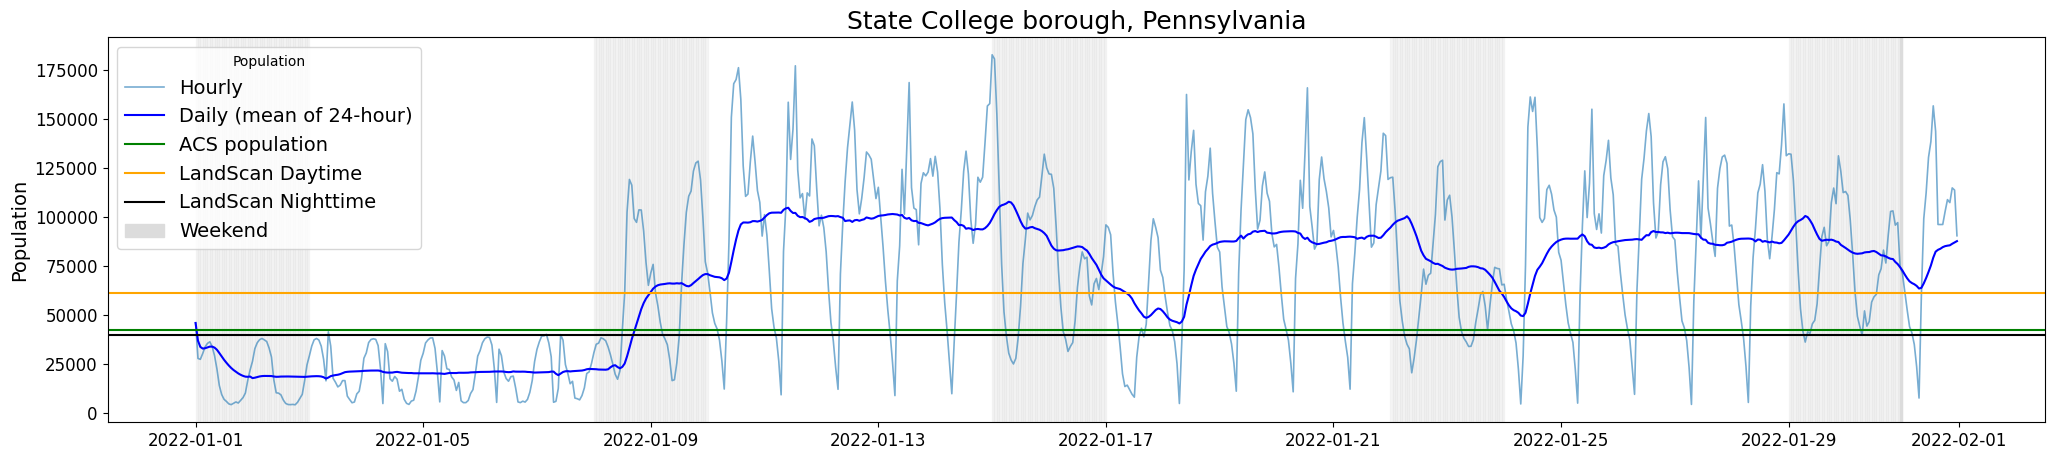

In [16]:
import matplotlib.pyplot as plt

def plot_population(df):
    fig, ax = plt.subplots(figsize = (25, 5))
    sum_series = df.iloc[:, 8:].sum()

    ACS_popu = sum_series.iloc[0]
    LandScan_day_popu = sum_series.iloc[1]
    LandScan_night_popu = sum_series.iloc[2]

    place_name = '_'.join(df[['NAMELSAD', 'STUSPS', 'place']].iloc[0].to_list())

    mini_popu_ratio = 0.1
    sum_series = sum_series.mask(sum_series < 0, ACS_popu * mini_popu_ratio)

    plt.plot(sum_series.iloc[3:], label="Hourly", alpha=0.6, linewidth=1.2)
    plt.plot(sum_series.iloc[3:].rolling(window=24, min_periods=1).mean(), label="Daily (mean of 24-hour)", color='blue', alpha=1)  # rolling 24 hours

    plt.axhline(y=ACS_popu, color = 'green', linestyle = '-', label="ACS population") 
    plt.axhline(y=LandScan_day_popu, color = 'orange', linestyle = '-', label="LandScan Daytime") 
    plt.axhline(y=LandScan_night_popu, color = 'black', linestyle = '-', label="LandScan Nighttime") 

    # grey weekends
    _, last_day = calendar.monthrange(year, months[-1])
    hourly_index = pd.date_range(start=f'{year}-{months[0]:02}-01', end=f'{year}-{months[-1]:02}-{last_day} 23:00:00', freq='H')
    for start in hourly_index[hourly_index.weekday >= 5]:
        plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=0.25)
        # ChatGPT make 'hours' as 'days', wrong! Hard to find!
    plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=1, label='Weekend')
    
    saved_fname = os.path.join(save_path, 'place_plots',   f"{place_name}_{year}_{months[-1]:02}.png")
    
    plt.title(df.iloc[0]['NAMELSAD'] + ", " + df.iloc[0]['STATE_NAME'], fontsize=18)
    
    # plt.title("Manhattan, New York", fontsize=18)
    
    plt.ylabel('Population', fontsize=14)
    plt.legend(title='Population', fontsize=12, title_fontsize=13)
    plt.savefig(saved_fname, dpi=150)
    plt.legend(title='Population', fontsize=14)
    plt.tick_params(axis='x', which='both', labelsize=12)
    plt.tick_params(axis='y', which='both', labelsize=12)
    
    # plt.close()
    plt.show()
 
plot_population(df)

## For Manhattan

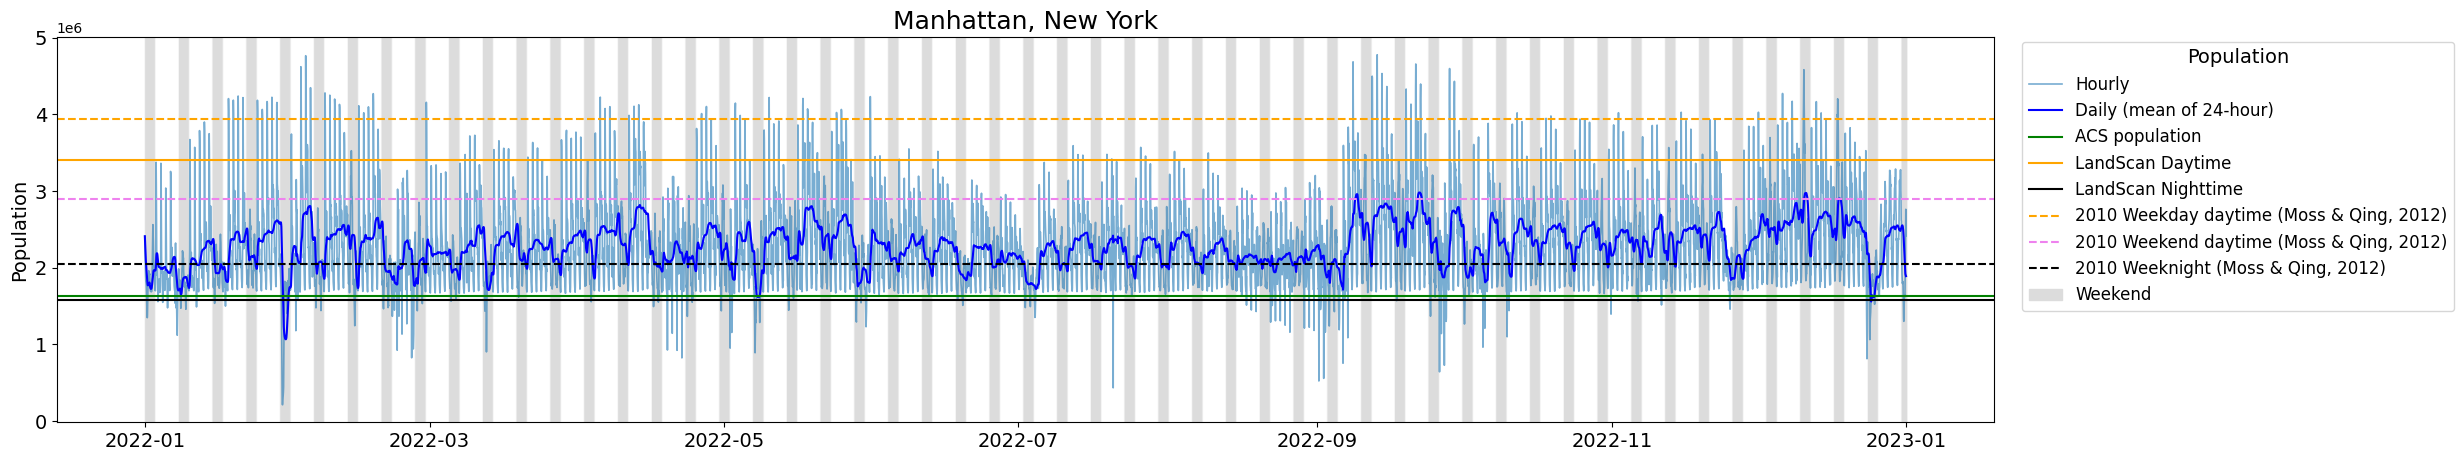

In [127]:
import matplotlib.pyplot as plt

def plot_population(df):
    fig, ax = plt.subplots(figsize = (25, 5))
    sum_series = df.iloc[:, 8:].sum()

    ACS_popu = sum_series.iloc[0]
    LandScan_day_popu = sum_series.iloc[1]
    LandScan_night_popu = sum_series.iloc[2]

    place_name = '_'.join(df[['NAMELSAD', 'STUSPS', 'place']].iloc[0].to_list())

    mini_popu_ratio = 0.1
    sum_series = sum_series.mask(sum_series < 0, ACS_popu * mini_popu_ratio)

    plt.plot(sum_series.iloc[3:], label="Hourly", alpha=0.6, linewidth=1.2)
    plt.plot(sum_series.iloc[3:].rolling(window=24, min_periods=1).mean(), label="Daily (mean of 24-hour)", color='blue', alpha=1)  # rolling 24 hours

    plt.axhline(y=ACS_popu, color = 'green', linestyle = '-', label="ACS population") 
    plt.axhline(y=LandScan_day_popu, color = 'orange', linestyle = '-', label="LandScan Daytime") 
    plt.axhline(y=LandScan_night_popu, color = 'black', linestyle = '-', label="LandScan Nighttime") 
    
    plt.axhline(y=3.94e6, color = 'orange', linestyle = '--', label="2010 Weekday daytime (Moss & Qing, 2012)") 
    plt.axhline(y=2.90e6, color = 'violet', linestyle = '--', label="2010 Weekend daytime (Moss & Qing, 2012)") 
    plt.axhline(y=2.05e6, color = 'black', linestyle = '--', label="2010 Weeknight (Moss & Qing, 2012)") 
    

    # grey weekends
    _, last_day = calendar.monthrange(year, months[-1])
    hourly_index = pd.date_range(start=f'{year}-{months[0]:02}-01', end=f'{year}-{months[-1]:02}-{last_day} 23:00:00', freq='H')
    for start in hourly_index[hourly_index.weekday >= 5]:
        plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=0.25)
        # ChatGPT make 'hours' as 'days', wrong! Hard to find!
    plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=1, label='Weekend')
    
    
    
    # plt.title(df.iloc[0]['NAMELSAD'] + ", " + df.iloc[0]['STATE_NAME'], fontsize=18)
    
    plt.title("Manhattan, New York", fontsize=18)
    
    plt.ylabel('Population', fontsize=14)
    plt.legend(title='Population', fontsize=14, title_fontsize=14)
    
    
    # plt.legend(title='Population', fontsize=14)
    plt.legend(title='Population', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.01, 1.01), loc='upper left')
    
    plt.tick_params(axis='x', which='both', labelsize=14)
    plt.tick_params(axis='y', which='both', labelsize=14)
    
    saved_fname = os.path.join(save_path, 'place_plots',   f"Manhattan_{year}.png")
    plt.savefig(saved_fname, dpi=150)
    # plt.close()
    plt.show()
 
plot_population(df)

## For Myrtle bearch city

In [76]:
df.iloc[:, 11:]

2022-01-01 00:00:00  2022-01-01 01:00:00  2022-01-01 02:00:00  \
90320               1383.0               1798.0               1897.0   
90374               1486.0               1504.0               1038.0   
90375               3236.0               3647.0               3712.0   
90376                836.0               1826.0               1133.0   
90377               1690.0               1971.0               1349.0   
...                    ...                  ...                  ...   
96358                535.0               1503.0               1285.0   
96359                872.0               1468.0               1669.0   
96360               3644.0               1344.0               1568.0   
96361               1180.0               2510.0               3307.0   
96362               2240.0               1504.0                815.0   

       2022-01-01 03:00:00  2022-01-01 04:00:00  2022-01-01 05:00:00  \
90320               1612.0               1491.0               1523.0   
90374                824.0                856.0                871.0   
90375               3204.0               2889.0               2727.0   
90376               1413.0                951.0                963.0   
90377               2172.0               1761.0               1554.0   
...                    ...                  ...                  ...   
96358               1299.0               2189.0               1868.0   
96359               1337.0                956.0               1022.0   
96360                719.0                392.0                584.0   
96361               2396.0               1889.0               1995.0   
96362               1397.0                940.0                966.0   

       2022-01-01 06:00:00  2022-01-01 07:00:00  2022-01-01 08:00:00  \
90320               1518.0               1868.0               1421.0   
90374                868.0               1625.0                824.0   
90375               2988.0               2605.0               2918.0   
90376               1205.0                950.0                924.0   
90377               1790.0               2243.0               1928.0   
...                    ...                  ...                  ...   
96358               2093.0               1929.0               1288.0   
96359               1271.0               1213.0               1074.0   
96360                403.0                569.0                896.0   
96361               1979.0               1886.0               2147.0   
96362                962.0               1194.0               1396.0   

       2022-01-01 09:00:00  ...  2022-12-31 14:00:00  2022-12-31 15:00:00  \
90320               1489.0  ...               1266.0                806.0   
90374               1022.0  ...                950.0                837.0   
90375               2490.0  ...                309.0                309.8   
90376                877.0  ...                464.0                474.0   
90377               1559.0  ...                267.0               1070.0   
...                    ...  ...                  ...                  ...   
96358                865.0  ...                245.0                198.0   
96359                829.0  ...                123.0                481.0   
96360               1198.0  ...               4434.0               3684.0   
96361               1757.0  ...                233.0                233.0   
96362                792.0  ...                117.0                104.7   

       2022-12-31 16:00:00  2022-12-31 17:00:00  2022-12-31 18:00:00  \
90320                868.0                933.0               1496.0   
90374               1189.0                262.0                680.0   
90375                309.0                309.0                309.0   
90376                919.0                530.0                596.0   
90377                519.0                274.0                578.0   
...                    ...                  ...        

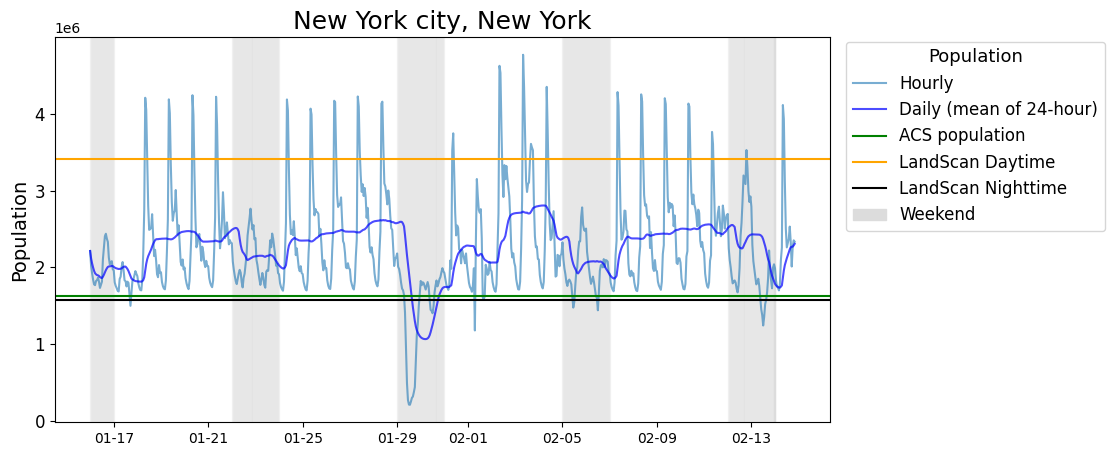

In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_population(df):
    
    start_hour = 24 * 15
    end_hour = start_hour + 24 * 30
    fig, ax = plt.subplots(figsize = (10, 5))
    sum_series = df.iloc[:, 8:].sum()

    ACS_popu = sum_series.iloc[0]
    LandScan_day_popu = sum_series.iloc[1]
    LandScan_night_popu = sum_series.iloc[2]

    place_name = '_'.join(df[['NAMELSAD', 'STUSPS', 'place']].iloc[0].to_list())

    mini_popu_ratio = 0.1
    sum_series = sum_series.mask(sum_series < 0, ACS_popu * mini_popu_ratio)

    plt.plot(sum_series.iloc[3 + start_hour:end_hour] , label="Hourly", alpha=0.6, linewidth=1.5)
    plt.plot(sum_series.iloc[3 + start_hour:end_hour].rolling(window=24, min_periods=1).mean(), label="Daily (mean of 24-hour)", color='blue', alpha=0.7)  # rolling 24 hours

    plt.axhline(y=ACS_popu, color = 'green', linestyle = '-', label="ACS population") 
    plt.axhline(y=LandScan_day_popu, color = 'orange', linestyle = '-', label="LandScan Daytime") 
    plt.axhline(y=LandScan_night_popu, color = 'black', linestyle = '-', label="LandScan Nighttime") 

    # grey weekends
    _, last_day = calendar.monthrange(year, months[-1])
    hourly_index = pd.date_range(start=f'{year}-{months[0]:02}-01', end=f'{year}-{months[-1]:02}-{last_day} 23:00:00', freq='H')[start_hour:end_hour] 
    for start in hourly_index[hourly_index.weekday >= 5]:
        plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=0.25)
        # ChatGPT make 'hours' as 'days', wrong! Hard to find!
    plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=1, label='Weekend')
    
    saved_fname = os.path.join(save_path, 'place_plots',   f"{place_name}_{year}_{months[-1]:02}.png")
    plt.title(df.iloc[0]['NAMELSAD'] + ", " + df.iloc[0]['STATE_NAME'], fontsize=18)
    plt.ylabel('Population', fontsize=14)
    plt.legend(title='Population', fontsize=12, title_fontsize=13, bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.savefig(saved_fname, dpi=150)
    # plt.legend(title='Population', fontsize=14)
    plt.tick_params(axis='x', which='both', labelsize=10)
    plt.tick_params(axis='y', which='both', labelsize=12)
    myFmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    
    # plt.close()
    plt.show()
 
plot_population(df)

In [78]:
df.shape[1] # df
# df

8771

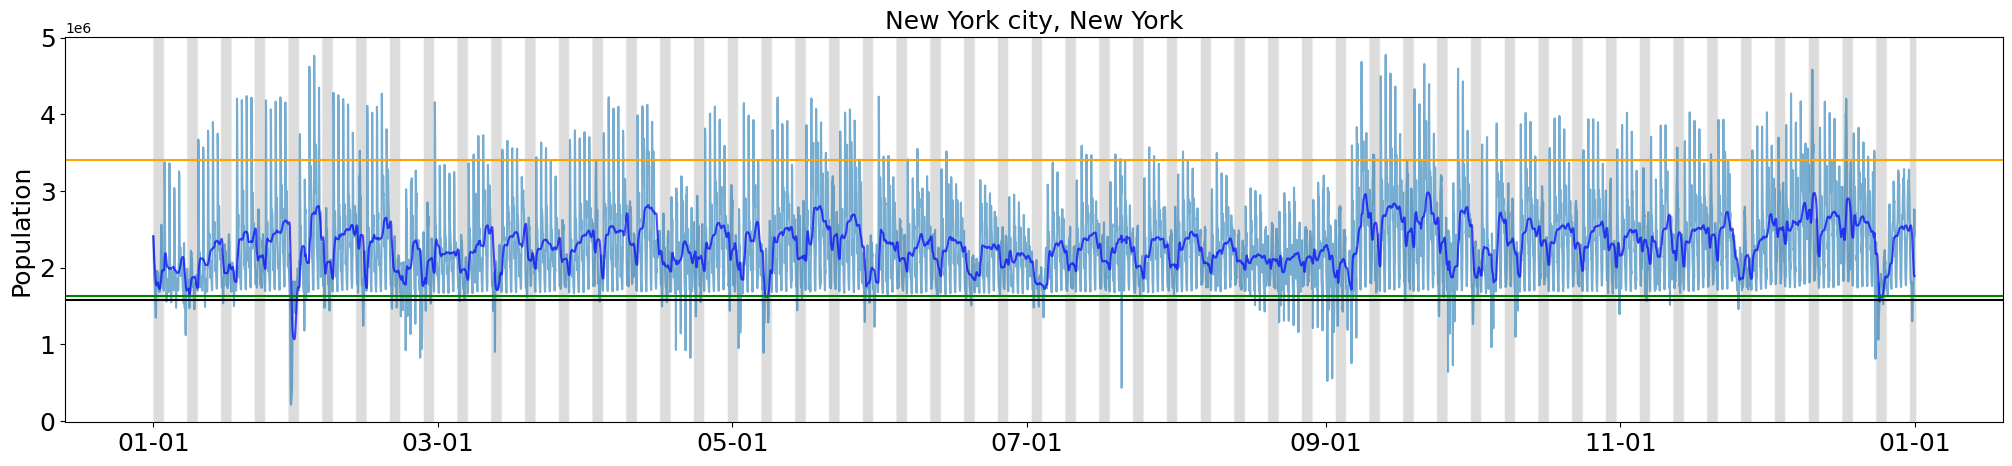

In [79]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_population(df):
    
    start_hour = 0
    end_hour = df.shape[1] 
    fig, ax = plt.subplots(figsize = (25, 5))
    sum_series = df.iloc[:, 8:].sum()

    ACS_popu = sum_series.iloc[0]
    LandScan_day_popu = sum_series.iloc[1]
    LandScan_night_popu = sum_series.iloc[2]

    place_name = '_'.join(df[['NAMELSAD', 'STUSPS', 'place']].iloc[0].to_list())

    mini_popu_ratio = 0.1
    sum_series = sum_series.mask(sum_series < 0, ACS_popu * mini_popu_ratio)

    plt.plot(sum_series.iloc[3 + start_hour:end_hour] , label="Hourly", alpha=0.6, linewidth=1.5)
    plt.plot(sum_series.iloc[3 + start_hour:end_hour].rolling(window=24, min_periods=1).mean(), label="Daily (mean of 24-hour)", color='blue', alpha=0.7)  # rolling 24 hours

    plt.axhline(y=ACS_popu, color = 'green', linestyle = '-', label="ACS population") 
    plt.axhline(y=LandScan_day_popu, color = 'orange', linestyle = '-', label="LandScan Daytime") 
    plt.axhline(y=LandScan_night_popu, color = 'black', linestyle = '-', label="LandScan Nighttime") 

    # grey weekends
    _, last_day = calendar.monthrange(year, months[-1])
    hourly_index = pd.date_range(start=f'{year}-{months[0]:02}-01', end=f'{year}-{months[-1]:02}-{last_day} 23:00:00', freq='H')[start_hour:end_hour] 
    for start in hourly_index[hourly_index.weekday >= 5]:
        plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=0.25)
        # ChatGPT make 'hours' as 'days', wrong! Hard to find!
    plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=1, label='Weekend')
    
    saved_fname = os.path.join(save_path, 'place_plots',   f"{place_name}_{year}_{months[-1]:02}.png")
    plt.title(df.iloc[0]['NAMELSAD'] + ", " + df.iloc[0]['STATE_NAME'], fontsize=18)
    plt.ylabel('Population', fontsize=18)
    # plt.legend(title='Population', fontsize=12, title_fontsize=13, bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.savefig(saved_fname, dpi=150)
    # plt.legend(title='Population', fontsize=14)
    plt.tick_params(axis='x', which='both', labelsize=18)
    plt.tick_params(axis='y', which='both', labelsize=18)
    myFmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    
    # plt.close()
    plt.show()
 
plot_population(df)

## Plot day-night time

C:\Users\USER\AppData\Local\Temp\ipykernel_15564\3085520835.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(saved_fname, dpi=300)
C:\Users\USER\.conda\envs\geo\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


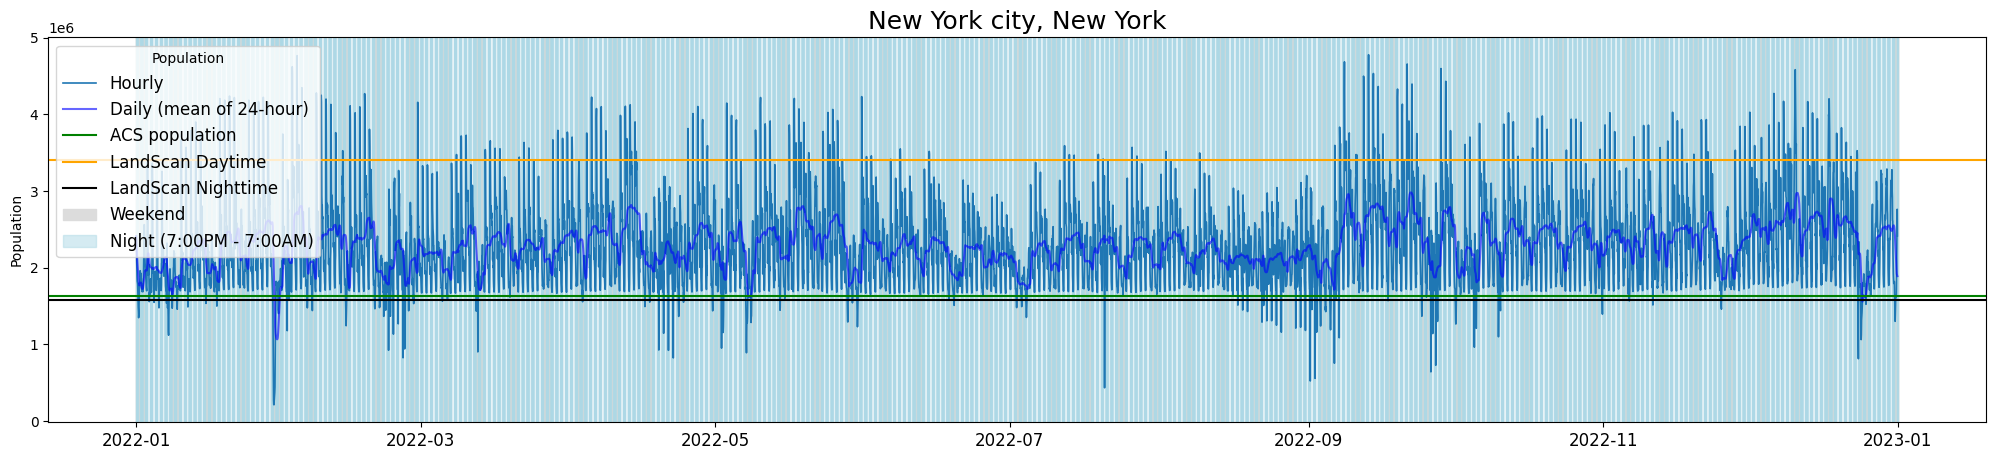

In [80]:
import matplotlib.pyplot as plt

def plot_population_day_night(df):
    fig, ax = plt.subplots(figsize = (25, 5))
    sum_series = df.iloc[:, 8:].sum()

    ACS_popu = sum_series.iloc[0]
    LandScan_day_popu = sum_series.iloc[1]
    LandScan_night_popu = sum_series.iloc[2]

    place_name = '_'.join(df[['NAMELSAD', 'STUSPS', 'place']].iloc[0].to_list())

    mini_popu_ratio = 0.1
    sum_series = sum_series.mask(sum_series < 0, ACS_popu * mini_popu_ratio)
    
    plt.plot(sum_series.iloc[3:], label="Hourly", alpha=1, linewidth=1.2)

    
    plt.plot(sum_series.iloc[3:].rolling(window=24, min_periods=1).mean(), label="Daily (mean of 24-hour)", color='blue', alpha=0.6)  # rolling 24 hours

    plt.axhline(y=ACS_popu, color = 'green', linestyle = '-', label="ACS population") 
    plt.axhline(y=LandScan_day_popu, color = 'orange', linestyle = '-', label="LandScan Daytime") 
    plt.axhline(y=LandScan_night_popu, color = 'black', linestyle = '-', label="LandScan Nighttime") 

    # grey weekends
    _, last_day = calendar.monthrange(year, months[-1])
    hourly_index = pd.date_range(start=f'{year}-{months[0]:02}-01', end=f'{year}-{months[-1]:02}-{last_day} 23:00:00', freq='H')
    
    for start in hourly_index[hourly_index.weekday >= 5]:  # Draw weekend
        plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=1)
    plt.axvspan(start, start + pd.Timedelta(hours=1), color='gainsboro', alpha=1, label='Weekend')
        
    for start in hourly_index:
        # print(start)
        if 7 < start.hour <= 19:  # day
            # print(start.hour)
            pass
        else:  # night  (19:00 - 7:00)
            # print(start.hour)
            plt.axvspan(start, start + pd.Timedelta(hours=1), color='lightblue', alpha=0.5)  #, color='gainsboro',  alpha=0.02
            
    plt.axvspan(start, start + pd.Timedelta(hours=1), color='lightblue', alpha=0.5, label='Night (7:00PM - 7:00AM)')
        # ChatGPT make 'hours' as 'days', wrong! Hard to find!
        
    

    saved_fname = os.path.join(save_path, 'place_plots',   f"{place_name}_{year}_{months[-1]:02}_daynight.png")  
    plt.title(df.iloc[0]['NAMELSAD'] + ", " + df.iloc[0]['STATE_NAME'], fontsize=18)
    plt.ylabel('Population')
    plt.legend(title='Population', fontsize=12)
    plt.tick_params(axis='x', which='both', labelsize=12)
    plt.savefig(saved_fname, dpi=300)
    # plt.close()
    plt.show()
 
plot_population_day_night(df)

In [81]:
hourly_index[hourly_index.hour >= 7]
hourly_index = pd.date_range(start=f'{year}-{months[0]:02}-01', end=f'{year}-{months[-1]:02}-{last_day} 23:00:00', freq='H')
hourly_index
hourly_index[24].hour

0

In [82]:
# STOP

# Show the map

In [17]:
CBG_2019_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\blockgoups2019.zip"
CBG_2019_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\blockgoups2019.zip"

In [18]:
CBG2019_gdf = gpd.read_file(CBG_2019_fname)
CBG2019_gdf['county_FIPS'] = CBG2019_gdf['GEOID'].astype(str).str.zfill(12).str[:5]
CBG2019_gdf['CBG'] = CBG2019_gdf['GEOID'].astype(str).str.zfill(12)


In [19]:
CBG2019_gdf

GEOID                                           geometry  \
0       010730059033  POLYGON ((-86.69206 33.60022, -86.69174 33.600...   
1       010730059031  POLYGON ((-86.68307 33.59456, -86.68297 33.594...   
2       010730059053  POLYGON ((-86.70049 33.61777, -86.70047 33.617...   
3       010730059051  POLYGON ((-86.71185 33.59383, -86.71176 33.593...   
4       010730057023  POLYGON ((-86.88311 33.47224, -86.88307 33.472...   
...              ...                                                ...   
220328  720210302002  POLYGON ((-66.14085 18.38643, -66.14022 18.389...   
220329  720210314012  POLYGON ((-66.16869 18.38156, -66.16750 18.382...   
220330  720210312021  POLYGON ((-66.18304 18.38045, -66.18263 18.380...   
220331  720531504003  POLYGON ((-65.64082 18.34100, -65.64019 18.341...   
220332  720531501044  POLYGON ((-65.63509 18.36540, -65.63474 18.365...   

       county_FIPS           CBG  
0            01073  010730059033  
1            01073  010730059031  
2            01073  010730059053  
3            01073  010730059051  
4            01073  010730057023  
...            ...           ...  
220328       72021  720210302002  
220329       72021  720210314012  
220330       72021  720210312021  
220331       72053  720531504003  
220332       72053  720531501044  

[220333 rows x 4 columns]

In [86]:
# df

In [20]:
# hourly_index
df

sub_area_ratio           CBG    place           NAME  \
120166        0.967830  420270127001  4273808  State College   
120167        1.000000  420270122001  4273808  State College   
120168        0.977047  420270127003  4273808  State College   
120169        1.000000  420270125002  4273808  State College   
120170        1.000000  420270121002  4273808  State College   
120171        0.995514  420270128001  4273808  State College   
120172        1.000000  420270125001  4273808  State College   
120173        1.000000  420270120005  4273808  State College   
120174        1.000000  420270120002  4273808  State College   
120175        0.992178  420270122003  4273808  State College   
120176        1.000000  420270127002  4273808  State College   
120177        0.967210  420270123001  4273808  State College   
120178        0.993286  420270120001  4273808  State College   
120179        1.000000  420270120003  4273808  State College   
120180        1.000000  420270120004  4273808  State College   
120181        1.000000  420270121001  4273808  State College   
120182        1.000000  420270122002  4273808  State College   
120183        0.987608  420270123002  4273808  State College   
120184        1.000000  420270124001  4273808  State College   
120185        0.970584  420270124002  4273808  State College   
120186        1.000000  420270124003  4273808  State College   
120187        1.000000  420270126001  4273808  State College   
120188        1.000000  420270126002  4273808  State College   
120189        0.989650  420270128002  4273808  State College   
120190        1.000000  420270128003  4273808  State College   
120191        1.000000  420270121003  4273808  State College   
120192        1.000000  420270121004  4273808  State College   

                     NAMELSAD STUSPS    STATE_NAME  \
120166  State College borough     PA  Pennsylvania   
120167  State College borough     PA  Pennsylvania   
120168  State College borough     PA  Pennsylvania   
120169  State College borough     PA  Pennsylvania   
120170  State College borough     PA  Pennsylvania   
120171  State College borough     PA  Pennsylvania   
120172  State College borough     PA  Pennsylvania   
120173  State College borough     PA  Pennsylvania   
120174  State College borough     PA  Pennsylvania   
120175  State College borough     PA  Pennsylvania   
120176  State College borough     PA  Pennsylvania   
120177  State College borough     PA  Pennsylvania   
120178  State College borough     PA  Pennsylvania   
120179  State College borough     PA  Pennsylvania   
120180  State College borough     PA  Pennsylvania   
120181  State College borough     PA  Pennsylvania   
120182  State College borough     PA  Pennsylvania   
120183  State College borough     PA  Pennsylvania   
120184  State College borough     PA  Pennsylvania   
120185  State College borough     PA  Pennsylvania   
120186  State College borough     PA  Pennsylvania   
120187  State College borough     PA  Pennsylvania   
120188  State College borough     PA  Pennsylvania   
120189  State College borough     PA  Pennsylvania   
120190  State College borough     PA  Pennsylvania   
120191  State College borough     PA  Pennsylvania   
120192  State College borough     PA  Pennsylvania   

                                                 geometry  totalpopulation  \
120166  MULTIPOLYGON (((-77.84396 40.79510, -77.84358 ...              701   
120167  MULTIPOLYGON (((-77.86418 40.80655, -77.86385 ...             2455   
120168  MULTIPOLYGON (((-77.85457 40.78255, -77.85426 ...             1328   
120169  MULTIPOLYGON (((-77.86441 40.79234, -77.86391 ...             1501   
120170  MULTIPOLYGON (((-77.86508 40.79584, -77.86501 ...             1226   
120171  MULTIPOLYGON (((-77.87073 40.77962, -77.87045 ...             1312   
120172  MULTIPOLYGON (((-77.85984 40.79575, -77.85979 ...             2879   
120173  MULTIPOLYGON (((-77.85635 40.79639, -77.85583 ...             1236   


In [21]:
year = 2022
month = 1
day = 19

hourly_index = pd.date_range(start=f'{year}-{month:02}-{day:02}', end=f'2022-{month:02}-{day:02} 23:00:00', freq='H')
try:
    day_df = df.set_index('CBG')
except: 
    pass
day_df = day_df[hourly_index]
vmax = day_df.mean(axis=1).mean() + day_df.mean(axis=1).std() * 3
print("vmax:", vmax)
day_df.max().max()
# hourly_index

vmax: 14785.040559656238


42342.0

In [40]:
# df.set_index('CBG')
day_df.max()

2022-01-19 00:00:00    15425.0
2022-01-19 01:00:00     9326.0
2022-01-19 02:00:00     7027.0
2022-01-19 03:00:00     3750.0
2022-01-19 04:00:00     3173.0
2022-01-19 05:00:00     2465.0
2022-01-19 06:00:00     2596.0
2022-01-19 07:00:00     4041.0
2022-01-19 08:00:00    21627.0
2022-01-19 09:00:00    27679.0
2022-01-19 10:00:00    34213.0
2022-01-19 11:00:00    40569.0
2022-01-19 12:00:00    39511.0
2022-01-19 13:00:00    42342.0
2022-01-19 14:00:00    39563.0
2022-01-19 15:00:00    20203.0
2022-01-19 16:00:00    17061.0
2022-01-19 17:00:00    17072.0
2022-01-19 18:00:00    19051.0
2022-01-19 19:00:00    21433.0
2022-01-19 20:00:00    19196.0
2022-01-19 21:00:00    19511.0
2022-01-19 22:00:00    18210.0
2022-01-19 23:00:00    16016.0
dtype: float64

In [90]:
df.query("CBG == '360610143001' ")

sub_area_ratio           CBG    place      NAME       NAMELSAD STUSPS  \
91921             1.0  360610143001  3651000  New York  New York city     NY   

      STATE_NAME                                           geometry  \
91921   New York  MULTIPOLYGON (((-73.98102 40.76927, -73.98056 ...   

       totalpopulation  landscan_day  ...  2022-12-31 14:00:00  \
91921                2        4268.0  ...              35371.0   

       2022-12-31 15:00:00  2022-12-31 16:00:00  2022-12-31 17:00:00  \
91921              36761.0              22371.0              10740.0   

       2022-12-31 18:00:00  2022-12-31 19:00:00  2022-12-31 20:00:00  \
91921              10841.0               8450.0               7903.0   

       2022-12-31 21:00:00  2022-12-31 22:00:00  2022-12-31 23:00:00  
91921               9069.0              12840.0              26008.0  

[1 rows x 8771 columns]

In [91]:
# df.index.astype(str).zfill(5
# merged_gdf

<Axes: >

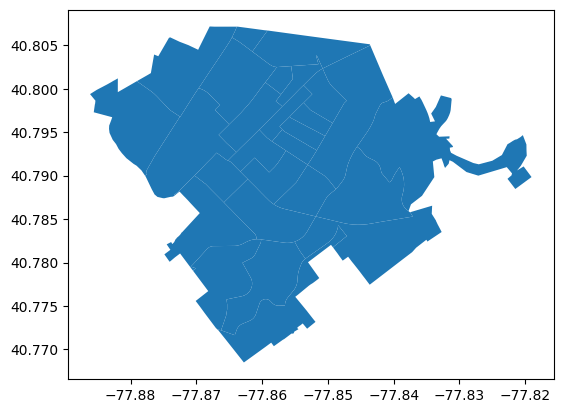

In [23]:
merged_gdf = CBG2019_gdf.merge(day_df, left_on='CBG', right_index=True)
merged_gdf.plot()

In [93]:
merged_gdf.columns.astype(str)

Index(['GEOID', 'geometry', 'county_FIPS', 'CBG', '2022-01-19 00:00:00',
       '2022-01-19 01:00:00', '2022-01-19 02:00:00', '2022-01-19 03:00:00',
       '2022-01-19 04:00:00', '2022-01-19 05:00:00', '2022-01-19 06:00:00',
       '2022-01-19 07:00:00', '2022-01-19 08:00:00', '2022-01-19 09:00:00',
       '2022-01-19 10:00:00', '2022-01-19 11:00:00', '2022-01-19 12:00:00',
       '2022-01-19 13:00:00', '2022-01-19 14:00:00', '2022-01-19 15:00:00',
       '2022-01-19 16:00:00', '2022-01-19 17:00:00', '2022-01-19 18:00:00',
       '2022-01-19 19:00:00', '2022-01-19 20:00:00', '2022-01-19 21:00:00',
       '2022-01-19 22:00:00', '2022-01-19 23:00:00'],
      dtype='object')

In [94]:
# merged_gdf.index = 

In [28]:
merged_gdf.columns[15]
merged_gdf

GEOID                                           geometry  \
166787  420270127001  POLYGON ((-77.84558 40.79333, -77.84396 40.795...   
166789  420270122001  POLYGON ((-77.86434 40.80630, -77.86418 40.806...   
166795  420270127003  POLYGON ((-77.85499 40.78241, -77.85457 40.782...   
166797  420270125002  POLYGON ((-77.86520 40.79174, -77.86441 40.792...   
166803  420270121002  POLYGON ((-77.86661 40.79469, -77.86508 40.795...   
167080  420270128001  POLYGON ((-77.87077 40.77960, -77.87073 40.779...   
168712  420270125001  POLYGON ((-77.86037 40.79537, -77.85984 40.795...   
168713  420270120005  POLYGON ((-77.85715 40.79581, -77.85635 40.796...   
168943  420270120002  POLYGON ((-77.85849 40.79394, -77.85817 40.794...   
169066  420270122003  POLYGON ((-77.87777 40.78996, -77.87752 40.790...   
169852  420270127002  POLYGON ((-77.85124 40.78610, -77.85042 40.787...   
170735  420270123001  POLYGON ((-77.87905 40.80088, -77.87875 40.801...   
170736  420270120001  POLYGON ((-77.85271 40.79168, -77.85227 40.792...   
170737  420270120003  POLYGON ((-77.85370 40.80042, -77.85350 40.800...   
170738  420270120004  POLYGON ((-77.85583 40.79678, -77.85539 40.797...   
170739  420270121001  POLYGON ((-77.85793 40.79856, -77.85713 40.799...   
170740  420270122002  POLYGON ((-77.86966 40.80008, -77.86927 40.800...   
170741  420270123002  POLYGON ((-77.88617 40.79939, -77.88574 40.799...   
170742  420270124001  POLYGON ((-77.86574 40.78697, -77.86524 40.787...   
170744  420270124002  POLYGON ((-77.87487 40.78094, -77.87395 40.781...   
170745  420270124003  POLYGON ((-77.87022 40.79006, -77.86974 40.790...   
170746  420270126001  POLYGON ((-77.86297 40.79068, -77.86268 40.790...   
170781  420270126002  POLYGON ((-77.85823 40.78670, -77.85721 40.787...   
170782  420270128002  POLYGON ((-77.86672 40.77227, -77.86656 40.772...   
170783  420270128003  POLYGON ((-77.86578 40.77320, -77.86548 40.773...   
173728  420270121003  POLYGON ((-77.85952 40.80074, -77.85810 40.802...   
173730  420270121004  POLYGON ((-77.86149 40.80429, -77.86104 40.804...   

       county_FIPS           CBG  2022-01-19 00:00:00  2022-01-19 01:00:00  \
166787       42027  420270127001                  421                  538   
166789       42027  420270122001                15425                 9326   
166795       42027  420270127003                 1114                 1101   
166797       42027  420270125002                 4177                 1947   
166803       42027  420270121002                 3001                 1623   
167080       42027  420270128001                  887                 1065   
168712       42027  420270125001                 7915                 6119   
168713       42027  420270120005                 2514                 2453   
168943       42027  420270120002                 2161                 2094   
169066       42027  420270122003                 2662                 1822   
169852       42027  420270127002                 1122                 1293   
170735       42027  420270123001                  801                  884   
170736       42027  420270120001                 1218                 1692   
170737       42027  420270120003                 4868                 3051   
170738       42027  420270120004                  463                  518   
170739       42027  420270121001                 2877                 2644   
170740       42027  420270122002                 2027                  843   
170741       42027  420270123002                  863                  993   
170742       42027  420270124001                 1004                 1003   
170744       42027  420270124002                 2345                 2404   
170745       42027  420270124003                 4824                 4717   
170746       42027  420270126001                 3780                 3236   
170781       42027  420270126002                 1118                 1213   
170782       42027  420270128002          

In [29]:
# t = merged_gdf.copy()
# t.columns = t.columns.astype(str)
# t.query("CBG == '360610143001' ").explore()
# central_park = '360610143001'
merged_gdf.explore(column='2022-01-19 08:00:00')

KeyError: '2022-01-19 08:00:00'

In [ ]:
t.query("CBG == '360610143001' ").iloc[:, 4:].sum().sum()  # 360610143001: Central park
t.query("CBG == '360610143001' ").iloc[:, 4:].T.plot()

In [98]:
# df#.mean(axis=1).mean()

In [30]:
import calendar

# get the target days
def get_weekdays(year, day_list=[calendar.WEDNESDAY, calendar.SATURDAY, calendar.SUNDAY], occurrence=3):
    target_weekdays = []
    # print(year)

    for month in months:  # Iterate through months (1 to 12)
        _, last_day = calendar.monthrange(year, month)  # Get the last day of the month
        weekdays = [calendar.weekday(year, month, day) for day in range(1, last_day + 1)]  # get the weekdays (0 - 6) of each day in this month
        # print(weekdays)
        # print("len of weekdays:", len(weekdays))

        # Find the third occurrence of target weekdays, e.g., Wednesday, Saturday, and Sunday
        for weekday in day_list:
            # print(weekday)
            occurrences = [day for day, wday in enumerate(weekdays, start=1) if wday == weekday]
            # print(occurrences)
            if len(occurrences) >= occurrence:
                day_name = calendar.day_name[calendar.weekday(year, month, occurrences[2])]
                day_dict = {"month": month, "day": occurrences[2], "day_name": day_name}
                target_weekdays.append(day_dict)
                # print(day_dict)

    return target_weekdays


year = 2022
third_weekdays_2022 = get_weekdays(year, day_list=[calendar.WEDNESDAY, calendar.SATURDAY, calendar.SUNDAY], occurrence=3)
    
third_weekdays_2022

[{'month': 1, 'day': 19, 'day_name': 'Wednesday'},
 {'month': 1, 'day': 15, 'day_name': 'Saturday'},
 {'month': 1, 'day': 16, 'day_name': 'Sunday'}]

In [37]:
# CBG_place_hourly_gdf
# df
# CBG2019_gdf
# df
# CBG2019_gdf.merge(df, left_on='GEOID', right_on='CBG')
# merged_gdf
# merged_gdf[['CBG', 'geometry']]
# CBG_place_hourly_gdf
# merged_gdf
# CBG_place_hourly_gdf
merged_gdf.iloc[4:]#.max()

GEOID                                           geometry  \
166803  420270121002  POLYGON ((-77.86661 40.79469, -77.86508 40.795...   
167080  420270128001  POLYGON ((-77.87077 40.77960, -77.87073 40.779...   
168712  420270125001  POLYGON ((-77.86037 40.79537, -77.85984 40.795...   
168713  420270120005  POLYGON ((-77.85715 40.79581, -77.85635 40.796...   
168943  420270120002  POLYGON ((-77.85849 40.79394, -77.85817 40.794...   
169066  420270122003  POLYGON ((-77.87777 40.78996, -77.87752 40.790...   
169852  420270127002  POLYGON ((-77.85124 40.78610, -77.85042 40.787...   
170735  420270123001  POLYGON ((-77.87905 40.80088, -77.87875 40.801...   
170736  420270120001  POLYGON ((-77.85271 40.79168, -77.85227 40.792...   
170737  420270120003  POLYGON ((-77.85370 40.80042, -77.85350 40.800...   
170738  420270120004  POLYGON ((-77.85583 40.79678, -77.85539 40.797...   
170739  420270121001  POLYGON ((-77.85793 40.79856, -77.85713 40.799...   
170740  420270122002  POLYGON ((-77.86966 40.80008, -77.86927 40.800...   
170741  420270123002  POLYGON ((-77.88617 40.79939, -77.88574 40.799...   
170742  420270124001  POLYGON ((-77.86574 40.78697, -77.86524 40.787...   
170744  420270124002  POLYGON ((-77.87487 40.78094, -77.87395 40.781...   
170745  420270124003  POLYGON ((-77.87022 40.79006, -77.86974 40.790...   
170746  420270126001  POLYGON ((-77.86297 40.79068, -77.86268 40.790...   
170781  420270126002  POLYGON ((-77.85823 40.78670, -77.85721 40.787...   
170782  420270128002  POLYGON ((-77.86672 40.77227, -77.86656 40.772...   
170783  420270128003  POLYGON ((-77.86578 40.77320, -77.86548 40.773...   
173728  420270121003  POLYGON ((-77.85952 40.80074, -77.85810 40.802...   
173730  420270121004  POLYGON ((-77.86149 40.80429, -77.86104 40.804...   

       county_FIPS           CBG  2022-01-16 00:00:00  2022-01-16 01:00:00  \
166803       42027  420270121002                 3610                 2834   
167080       42027  420270128001                  593                  851   
168712       42027  420270125001                19537                22385   
168713       42027  420270120005                 7606                 7383   
168943       42027  420270120002                 3924                 4725   
169066       42027  420270122003                 4156                 2480   
169852       42027  420270127002                  841                 1477   
170735       42027  420270123001                 1004                  784   
170736       42027  420270120001                 3509                 3420   
170737       42027  420270120003                 8038                 7699   
170738       42027  420270120004                 1052                 1132   
170739       42027  420270121001                 2372                 3064   
170740       42027  420270122002                 2749                 2263   
170741       42027  420270123002                 2061                  837   
170742       42027  420270124001                  881                  773   
170744       42027  420270124002                 4294                 3198   
170745       42027  420270124003                12579                10290   
170746       42027  420270126001                 5165                 6523   
170781       42027  420270126002                  851                 1410   
170782       42027  420270128002                 3267                 2659   
170783       42027  420270128003                 1627                 1788   
173728       42027  420270121003                 8089                 9012   
173730       42027  420270121004                 1180                 1012   

        2022-01-16 02:00:00  2022-01-16 03:00:00  2022-01-16 04:00:00  \
166803                 3638                 2442                 1584   
167080                  999                 1103                 1154   
168712                17057                10908                 6113   
168713                 3488                 2369 

In [31]:
# get the place code list by the LandScan daytime population
groupped_df = CBG_place_hourly_gdf.groupby(['NAMELSAD', 'STUSPS', 'place'])['landscan_day'].sum().sort_values(ascending=False).to_frame().reset_index()
sorted_place_list = groupped_df['place'].to_list()
print(len(sorted_place_list))

11845


## Generating map

In [32]:
place_name = "Manhattan, NY"
# place_name = "State College, PA"
# place_name = 'Myrtle Beach, SC'
# place_name = 'Columbia, SC'
# place_name = 'Ocean City, MD'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_target_gdf(year, month, day, df):
    # print(year, month, day)
    hourly_index = pd.date_range(start=f'{year}-{month:02}-{day:02}', end=f'{year}-{month:02}-{day:02} 23:00:00', freq='H')
    # print("hourly_index:", hourly_index)
    df = df[hourly_index]
    # vmax = df.mean(axis=1).mean() + df.mean(axis=1).std() * 3
    # print("vmax:", vmax)
    merged_gdf = CBG2019_gdf.merge(df, left_on='GEOID', right_index=True)
    
    return hourly_index, merged_gdf
 

def draw_map(hourly_index, merged_gdf, df, day_dict):     
        
    place_name = f"{df.iloc[0]['NAME']}, {df.iloc[0]['STATE_NAME']}"
    row_cnt = 3
    col_cnt = 9
 

    fig = plt.figure(figsize=(20, 7.5))
    ax_idx = 0
    
    if len(df) > 2:
    
        vmax = merged_gdf.iloc[:, 4:].mean(axis=1).mean() + merged_gdf.iloc[:, 4:].mean(axis=1).std() * 3
        vmin = 0
    else: 
        vmax = merged_gdf.iloc[:, 4:].max(axis=1).max()
        vmin = 0
    
    # print('vmax:', vmax)
    # print('vmin:', vmin)

    cmap = 'viridis'
    hour_column = 0

    for row in range(1, row_cnt + 1):    
        for col in range(1, col_cnt + 1):   
            ax_idx += 1
            if col == (col_cnt):
                # print("skip: col = ", col)
                continue                  
            # print("row, col, ax_idx, hour_column:", row, col, ax_idx, hour_column)

            ax = fig.add_subplot(row_cnt, col_cnt, ax_idx)
            ax.axis('off')
            ax.set_title(f"{hour_column:02}:00:00")

            merged_gdf.plot(column=hourly_index[hour_column],  ax=ax, vmax=vmax, cmap=cmap, vmin=vmin) 
            # merged_gdf.plot(column=hourly_index[hour_column],  ax=ax, cmap=cmap)
            # print("merged_gdf:", merged_gdf)
            # print("hourly_index[hour_column]:", hourly_index[hour_column])
            # print("hour_column:", hour_column)

            hour_column = hour_column + 1

            if hour_column == 24:
                break
        if hour_column == 24:
            break    
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    ACS_LandScan_gdf = merged_gdf[['CBG', 'geometry']].merge(ACS_df.loc[df.index], left_on='CBG', right_index=True)
    # print(ACS_LandScan_gdf)

    ax = fig.add_subplot(2, col_cnt,  9)
    ax.axis('off')
    ax.set_title(f"ACS 2019 Population")
    ACS_popu_df = ACS_LandScan_gdf.plot(column='totalpopulation',  ax=ax, vmax=vmax, vmin=vmin, cmap=cmap)
    new_position = [0.87, 0.56, 0.12, 0.35]  # [left, bottom, width, height]
    ax.set_position(new_position)


    # hourly population
    ax = fig.add_subplot(2, col_cnt,  18)
#     # ax.axis('off')
    hourly_popu_list = merged_gdf[hourly_index].sum().to_list()
    ax.plot(hourly_popu_list, label='Hourly')
    ax.axhline(ACS_LandScan_gdf['totalpopulation'].sum(), color='green', label='ACS 2019')
    ax.axhline(ACS_LandScan_gdf['landscan_day'].sum(), color='orange', label='LandScan Daytime')
    ax.axhline(ACS_LandScan_gdf['landscan_night'].sum(), color='black', label='LandScan Nighttime')
    ax.set_title('Population')
    ax.legend(framealpha=0.1, edgecolor="0.1")
    new_position = [0.87, 0.15, 0.12, 0.39]  # [left, bottom, width, height]
    ax.set_position(new_position)

    fig.suptitle(f"{place_name} Hourly Population ({year:04}-{month:02}-{day:02}, {day_dict['day_name']})", fontsize=20)

    

    # Add colorbar axes at the bottom and align it with the left and right of the subplots
    # pos1 = axs[0, 0].get_position() # get the original position for first axis
    # pos2 = axs[-1, -1].get_position()
    cax = fig.add_axes([0.07, 0.14, 0.007, 0.74])    # [left, bottom, width, height]  # bottom
    value_max =vmax
    value_min = vmin

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
    sm._A = []
    # plt.colorbar(sm, cax=cax, label="Bias")
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')

    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(16)

    cbar.set_label('Population', labelpad=-65,   rotation=90, fontsize=14, loc='center')

    png_name = os.path.join(save_path, f"{place_name.replace(', ', '_')}_hourly_population_{year}{month:02}{day:02}_{day_dict['day_name']}_{df.iloc[0]['place']}_v4.png")
     
     
    plt.savefig(png_name, dpi=100, bbox_inches='tight', pad_inches=0.2)
    plt.close()
    
    print("PNG name:", png_name)

 
total_place = CBG_place_hourly_gdf['place'].nunique()

processed_cnt = 0


# get the place code list by the LandScan daytime population
groupped_df = CBG_place_hourly_gdf.groupby(['NAMELSAD', 'STUSPS', 'place'])['landscan_day'].sum().sort_values(ascending=False).to_frame().reset_index()
sorted_place_list = groupped_df['place'].to_list()

# for idx, df in CBG_place_hourly_gdf.groupby(['NAMELSAD', 'STUSPS', 'place']): 
# for idx, df in CBG_place_hourly_gdf.query('NAME == "Myrtle Beach" ').groupby(['NAMELSAD', 'STUSPS', 'place']): 
# df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['CBG'].str.startswith('36061')]

for idx, place_code in enumerate(sorted_place_list):
    # df = CBG_place_hourly_gdf.query(f'place == "{place_code}" ')
    # df = CBG_place_hourly_gdf[CBG_place_hourly_gdf['CBG'].str.startswith('36061')]  # Manhattan, NY
    df = CBG_place_hourly_gdf.query('NAME == "State College" ')

    print(f"Processing {idx + 1} / {total_place}: {df.iloc[0][['NAMELSAD', 'STUSPS', 'place']].to_list()}")

    df = df.set_index("CBG")
    
    mini_popu_ratio = 0.1
    ACS_popu = df.iloc[0]['totalpopulation']
    df.iloc[:, 10:] = df.iloc[:, 10:].mask(df.iloc[:, 10:] < 0, ACS_popu * mini_popu_ratio)
    
    for day_dict in third_weekdays_2022:
        try:
            month = day_dict['month']
            day = day_dict['day']
            hourly_index, merged_gdf = get_target_gdf(year, month, day, df)
            print(year, month, day)
            draw_map(hourly_index, merged_gdf, df, day_dict)
        except Exception as e:
            print(e)
            # break
            # continue
            
    processed_cnt += 1
    
    break

Processing 1 / 11845: ['State College borough', 'PA', '4273808']
2022 1 19
PNG name: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population\State College_Pennsylvania_hourly_population_20220119_Wednesday_4273808_v4.png
2022 1 15
PNG name: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population\State College_Pennsylvania_hourly_population_20220115_Saturday_4273808_v4.png
2022 1 16
PNG name: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population\State College_Pennsylvania_hourly_population_20220116_Sunday_4273808_v4.png


In [103]:
# merged_gdf
CBG_place_hourly_gdf
df
merged_gdf
df

df.iloc[:, 10:].mean(axis=1)#.std()# * 3
df


sub_area_ratio    place      NAME       NAMELSAD STUSPS  \
CBG                                                                     
360610078001             1.0  3651000  New York  New York city     NY   
360610050004             1.0  3651000  New York  New York city     NY   
360610044007             1.0  3651000  New York  New York city     NY   
360610063004             1.0  3651000  New York  New York city     NY   
360610064005             1.0  3651000  New York  New York city     NY   
...                      ...      ...       ...            ...    ...   
360610136001             1.0  3651000  New York  New York city     NY   
360610136002             1.0  3651000  New York  New York city     NY   
360610137002             1.0  3651000  New York  New York city     NY   
360610138002             1.0  3651000  New York  New York city     NY   
360610138003             1.0  3651000  New York  New York city     NY   

             STATE_NAME                                           geometry  \
CBG                                                                          
360610078001   New York  MULTIPOLYGON (((-73.97497 40.74850, -73.97359 ...   
360610050004   New York  MULTIPOLYGON (((-73.98829 40.73466, -73.98782 ...   
360610044007   New York  MULTIPOLYGON (((-73.98156 40.73264, -73.98084 ...   
360610063004   New York  MULTIPOLYGON (((-73.99902 40.73415, -73.99862 ...   
360610064005   New York  MULTIPOLYGON (((-73.97850 40.73679, -73.97891 ...   
...                 ...                                                ...   
360610136001   New York  MULTIPOLYGON (((-73.95034 40.77556, -73.94982 ...   
360610136002   New York  MULTIPOLYGON (((-73.95126 40.77429, -73.95078 ...   
360610137002   New York  MULTIPOLYGON (((-73.97670 40.76500, -73.97720 ...   
360610138002   New York  MULTIPOLYGON (((-73.95363 40.77529, -73.95409 ...   
360610138003   New York  MULTIPOLYGON (((-73.95633 40.77560, -73.95409 ...   

              totalpopulation  landscan_day  landscan_night  ...  \
CBG                                                          ...   
360610078001             1627        2266.0          1107.0  ...   
360610050004              919        2595.0          1674.0  ...   
360610044007             3098         940.0          2533.0  ...   
360610063004             1004        1253.0           592.0  ...   
360610064005             1664         748.0           278.0  ...   
...                       ...           ...             ...  ...   
360610136001             2455        1488.0          2389.0  ...   
360610136002             1232        1383.0          1657.0  ...   
360610137002              450        4120.0           631.0  ...   
360610138002             2332         554.0           914.0  ...   
360610138003             1047         847.0           510.0  ...   

              2022-12-31 14:00:00  2022-12-31 15:00:00  2022-12-31 16:00:00  \
CBG                                                                           
360610078001               1266.0                806.0                868.0   
360610050004                950.0                837.0               1189.0   
360610044007                309.0                162.7                309.0   
360610063004                464.0                474.0                919.0   
360610064005                267.0               1070.0                519.0   
...                           ...                  ...                  ...   
360610136001                245.0                198.0                245.0   
360610136002                123.0                481.0                493.0   
360610137002               4434.0               3684.0               2272.0   
360610138002                233.0                233.0                233.0   
360610138003                117.0                162.7                304.0   

              2022-12-31 17:00:00  2022-12-31 18:00:00  2022-12-31 19:00:00  \
CBG                                                      

In [104]:
df.iloc[:, 10:]
mini_popu_ratio = 0.1
ACS_popu = df.iloc[0]['totalpopulation']
df.iloc[:, 10:] = df.iloc[:, 10:].mask(df.iloc[:, 10:] < 0, ACS_popu * mini_popu_ratio)
df

sub_area_ratio    place      NAME       NAMELSAD STUSPS  \
CBG                                                                     
360610078001             1.0  3651000  New York  New York city     NY   
360610050004             1.0  3651000  New York  New York city     NY   
360610044007             1.0  3651000  New York  New York city     NY   
360610063004             1.0  3651000  New York  New York city     NY   
360610064005             1.0  3651000  New York  New York city     NY   
...                      ...      ...       ...            ...    ...   
360610136001             1.0  3651000  New York  New York city     NY   
360610136002             1.0  3651000  New York  New York city     NY   
360610137002             1.0  3651000  New York  New York city     NY   
360610138002             1.0  3651000  New York  New York city     NY   
360610138003             1.0  3651000  New York  New York city     NY   

             STATE_NAME                                           geometry  \
CBG                                                                          
360610078001   New York  MULTIPOLYGON (((-73.97497 40.74850, -73.97359 ...   
360610050004   New York  MULTIPOLYGON (((-73.98829 40.73466, -73.98782 ...   
360610044007   New York  MULTIPOLYGON (((-73.98156 40.73264, -73.98084 ...   
360610063004   New York  MULTIPOLYGON (((-73.99902 40.73415, -73.99862 ...   
360610064005   New York  MULTIPOLYGON (((-73.97850 40.73679, -73.97891 ...   
...                 ...                                                ...   
360610136001   New York  MULTIPOLYGON (((-73.95034 40.77556, -73.94982 ...   
360610136002   New York  MULTIPOLYGON (((-73.95126 40.77429, -73.95078 ...   
360610137002   New York  MULTIPOLYGON (((-73.97670 40.76500, -73.97720 ...   
360610138002   New York  MULTIPOLYGON (((-73.95363 40.77529, -73.95409 ...   
360610138003   New York  MULTIPOLYGON (((-73.95633 40.77560, -73.95409 ...   

              totalpopulation  landscan_day  landscan_night  ...  \
CBG                                                          ...   
360610078001             1627        2266.0          1107.0  ...   
360610050004              919        2595.0          1674.0  ...   
360610044007             3098         940.0          2533.0  ...   
360610063004             1004        1253.0           592.0  ...   
360610064005             1664         748.0           278.0  ...   
...                       ...           ...             ...  ...   
360610136001             2455        1488.0          2389.0  ...   
360610136002             1232        1383.0          1657.0  ...   
360610137002              450        4120.0           631.0  ...   
360610138002             2332         554.0           914.0  ...   
360610138003             1047         847.0           510.0  ...   

              2022-12-31 14:00:00  2022-12-31 15:00:00  2022-12-31 16:00:00  \
CBG                                                                           
360610078001               1266.0                806.0                868.0   
360610050004                950.0                837.0               1189.0   
360610044007                309.0                162.7                309.0   
360610063004                464.0                474.0                919.0   
360610064005                267.0               1070.0                519.0   
...                           ...                  ...                  ...   
360610136001                245.0                198.0                245.0   
360610136002                123.0                481.0                493.0   
360610137002               4434.0               3684.0               2272.0   
360610138002                233.0                233.0                233.0   
360610138003                117.0                162.7                304.0   

              2022-12-31 17:00:00  2022-12-31 18:00:00  2022-12-31 19:00:00  \
CBG                                                      

<Axes: >

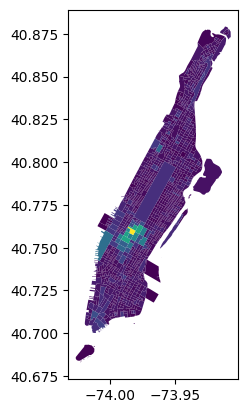

In [105]:
fig, ax = plt.subplots()
merged_gdf.plot(column=hourly_index[22],  ax=ax ) 

In [106]:
total_place = CBG_place_hourly_gdf['place'].nunique()
processed_cnt = 0
for idx, df in CBG_place_hourly_gdf.groupby(['NAMELSAD', 'STUSPS', 'place']):
    processed_cnt += 1
    if processed_cnt < 695:
        continue
    print(f"Processing {processed_cnt} / {total_place}: {idx}")
    plot_population(df)
    # break

TypeError: 'value' must be an instance of str or bytes, not a pandas._libs.tslibs.timestamps.Timestamp

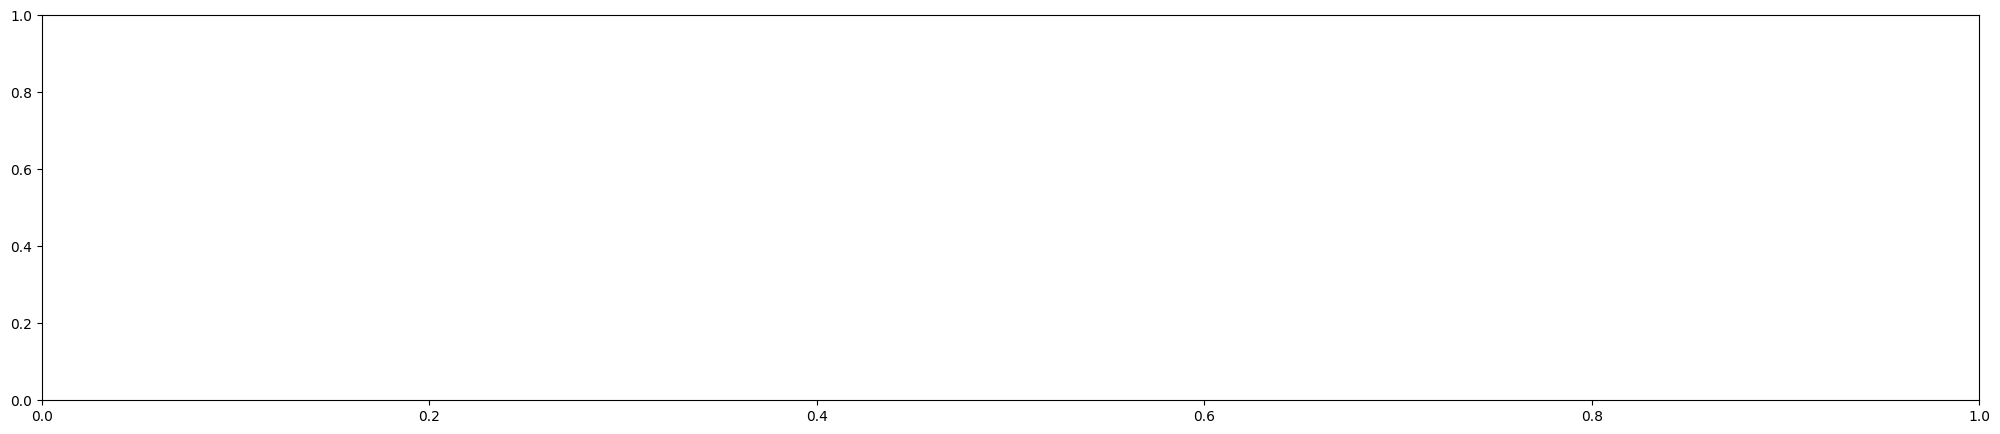

In [107]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (25, 5))
sum_series = df.iloc[:, 8:].sum()

ACS_popu = sum_series.iloc[0]
sum_series = sum_series.mask(sum_series < 0, ACS_popu)

plt.plot(sum_series.iloc[1:])
plt.axhline(y =ACS_popu, color = 'r', linestyle = '-', lw=0.3) 

hourly_index = pd.date_range(start='2022-01-01', end='2022-12-31 23:00:00', freq='H')
for start in hourly_index[hourly_index.weekday >= 5]:
    plt.axvspan(start, start + pd.Timedelta(days=1), color='lightgrey', alpha=0.1)
    
sum_series

In [ ]:
sum_series.iloc[1:].rolling(window=24, min_periods=1).mean()

In [ ]:
df

In [ ]:
STOP

# Tools

# Creating the mapping between Places and Census block groups

In [ ]:
CBG_boundary_2019 = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\blockgoups\blockgoups2019.shp'
place_boundary_2019 = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\vectors\cb_2023_us_place_500k.zip"

In [ ]:
CBG_gdf = gpd.read_file(CBG_boundary_2019)
CBG_gdf

In [ ]:
place_gdf = gpd.read_file(place_boundary_2019)
place_gdf

In [ ]:
CBG_gdf['area_deg'] = CBG_gdf.area
CBG_gdf

In [ ]:
inter_gdf = CBG_gdf.overlay(place_gdf, how='intersection')
inter_gdf

In [ ]:
inter_gdf['sub_area_deg'] = inter_gdf.area
inter_gdf['sub_area_ratio'] = inter_gdf['sub_area_deg'] / inter_gdf['area_deg']

inter_gdf

In [ ]:
inter_gdf.query('sub_area_ratio > 0.5')

In [ ]:
saved_fname = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\vectors\CBG_place.gpkg'
inter_gdf[['sub_area_ratio', 'GEOID_1', 'GEOID_2', 'NAME', 'NAMELSAD', 'STUSPS', 'STATE_NAME', 'geometry']].rename(columns={"GEOID_1":"CBG", "GEOID_2":"place"}).query('sub_area_ratio > 0.5').to_file(saved_fname, driver="GPKG")